In [1]:
# Evaluate the ML model

import tensorflow as tf
from tensorflow import keras
import os
import glob
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import plot_loss, encoder_files_to_tensors, get_best_model_timestamp
from utils import load_model_data_new, unnormalize_params, assess_decoder
from utils import sample_files
from models import EncoderMulti, mse_loss_encoder, mse_loss_decoder

# data_dir = '/eos/user/k/kiliakis/tomo_data/datasets'
data_dir = './tomo_data/datasets'

dataset_percent = 1
normalization = 'minmax'
num_Turns_Case = 50+1

var_names = ['phEr', 'enEr', 'bl',
             'inten', 'Vrf', 'mu', 'VrfSPS']


2022-11-24 09:58:28.488382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 09:58:28.728362: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-24 09:58:28.777517: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib:/usr/lib/x86_64-linux-gnu
2022-11-24 09:58:28.777529: I tensorflow/st

In [2]:
# Initialize parameters
import time

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
TESTING_PATH = os.path.join(ML_dir, 'TESTING')
assert os.path.exists(TESTING_PATH)


# First the training data
file_names = sample_files(TESTING_PATH, dataset_percent, keep_every=num_Turns_Case)

start_t = time.time()
# read input, divide in features/ label, create tensors
x_test, y_test = encoder_files_to_tensors(file_names, normalization=normalization)
total_time = time.time() - start_t
print(f'Elapsed time: {total_time:.3f}, Per file: {total_time/len(file_names):.3f}')


2022-11-24 09:58:45.169330: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib:/usr/lib/x86_64-linux-gnu
2022-11-24 09:58:45.169513: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-24 09:58:45.169529: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist
2022-11-24 09:58:45.170990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Elapsed time: 120.711, Per file: 0.087


In [3]:
# Model to load
# timestamp = get_best_model_timestamp('./trials', model='enc')
# timestamp = '2022_10_07_15-18-55'
# timestamp = '2022_09_30_17-46-45'
# timestamp = '2022_10_24_12-28-57'
timestamp = 'hybrid'

print(timestamp)

# Initialize directories
trial_dir = os.path.join('./trials/', timestamp)
weights_dir = os.path.join(trial_dir, 'weights')
plots_dir = os.path.join(trial_dir, 'plots')
assert os.path.exists(weights_dir)
os.makedirs(plots_dir, exist_ok=True)

models = {}
# load the model
for file in os.listdir(weights_dir):
    var_name = file.split('encoder_')[1].split('.h5')[0]
    models[var_name] = keras.models.load_model(os.path.join(weights_dir, file))


hybrid


In [4]:
test_losses = {}
for var_name, model in models.items():
    idx = var_names.index(var_name)
    print(f'------ Evaluating {var_name} ------')
    test_loss = model.evaluate(x_test, tf.gather(y_test, idx, axis=1))
    test_losses[var_name] = test_loss

for name, mse in test_losses.items():
    print(f'{name}:\t{mse:.3e}')

print(f'\nMean loss: {np.mean([v for v in test_losses.values()]):.3e}')


------ Evaluating enEr ------
44/44 [==============================] - 0s 4ms/step - loss: 7.0289e-05
------ Evaluating phEr ------
44/44 [==============================] - 0s 4ms/step - loss: 2.9769e-05
------ Evaluating bl ------
44/44 [==============================] - 0s 4ms/step - loss: 2.4089e-04
------ Evaluating inten ------
44/44 [==============================] - 0s 5ms/step - loss: 0.0824
------ Evaluating mu ------
44/44 [==============================] - 0s 9ms/step - loss: 0.0025
------ Evaluating Vrf ------
44/44 [==============================] - 0s 5ms/step - loss: 5.8979e-05
------ Evaluating VrfSPS ------
44/44 [==============================] - 0s 8ms/step - loss: 0.0030
enEr:	7.029e-05
phEr:	2.977e-05
bl:	2.409e-04
inten:	8.242e-02
mu:	2.495e-03
Vrf:	5.898e-05
VrfSPS:	3.019e-03

Mean loss: 1.262e-02


In [5]:
test_pred = np.zeros(shape=(len(x_test), len(models)), dtype=float)
for var_name, model in models.items():
    idx = var_names.index(var_name)
    print(f'------ Generating predictions for {var_name} ------')
    test_pred[:, idx] = model.predict(x_test, verbose=False).reshape(-1)

mses = mean_squared_error(y_test, test_pred, multioutput='raw_values')

for name, mse in zip(var_names, mses):
    print(f'{name}:\t{mse:.3e}')

print(f'\nMean loss: {np.mean(mses):.3e}')


------ Generating predictions for enEr ------
------ Generating predictions for phEr ------
------ Generating predictions for bl ------
------ Generating predictions for inten ------
------ Generating predictions for mu ------
------ Generating predictions for Vrf ------
------ Generating predictions for VrfSPS ------
phEr:	2.977e-05
enEr:	7.029e-05
bl:	2.409e-04
inten:	8.242e-02
Vrf:	5.898e-05
mu:	2.495e-03
VrfSPS:	3.019e-03

Mean loss: 1.262e-02


phEr [9.74747475e-01 1.73160173e-02 2.88600289e-03 2.88600289e-03
 7.21500722e-04 7.21500722e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.21500722e-04]
enEr [9.71139971e-01 2.23665224e-02 2.16450216e-03 1.44300144e-03
 7.21500722e-04 0.00000000e+00 7.21500722e-04 0.00000000e+00
 7.21500722e-04 7.21500722e-04]
bl [8.67965368e-01 9.81240981e-02 2.30880231e-02 7.21500722e-03
 7.21500722e-04 7.21500722e-04 1.44300144e-03 0.00000000e+00
 0.00000000e+00 7.21500722e-04]
inten [0.47186147 0.2020202  0.14718615 0.1046176  0.05266955 0.01731602
 0.0007215  0.0021645  0.0007215  0.0007215 ]
Vrf [9.33621934e-01 4.54545455e-02 1.29870130e-02 4.32900433e-03
 0.00000000e+00 0.00000000e+00 1.44300144e-03 7.21500722e-04
 0.00000000e+00 1.44300144e-03]
mu [9.75468975e-01 2.02020202e-02 2.88600289e-03 0.00000000e+00
 7.21500722e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.21500722e-04]
VrfSPS [0.86147186 0.08441558 0.02669553 0.01370851 0.002886   0.00577201
 0.001443   0.   

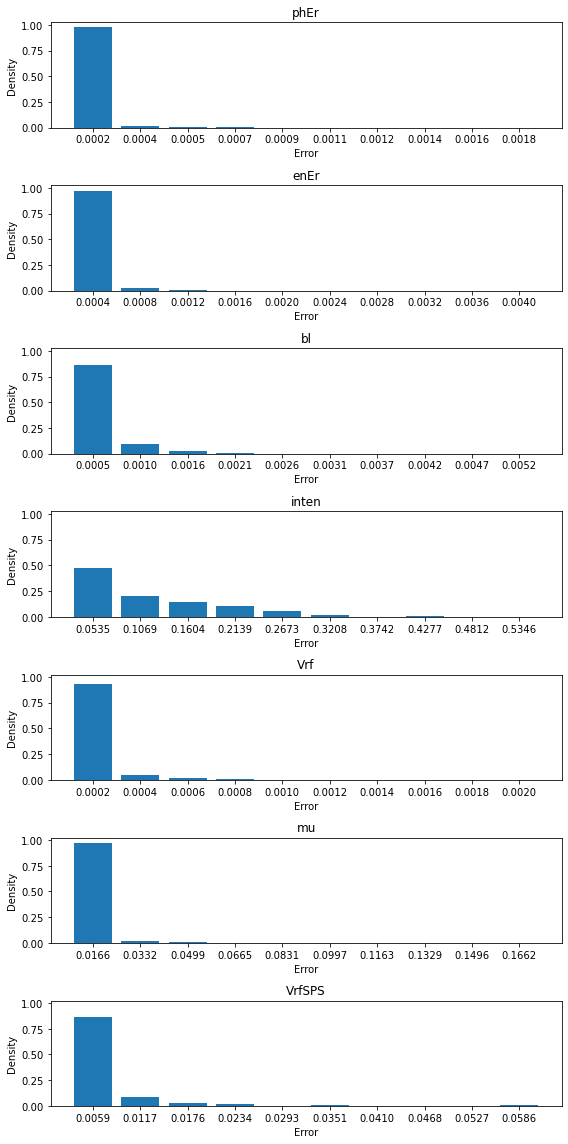

In [6]:
# Also generate MSE histogram
# print(valid_pred.shape)
square_errors = ((y_test - test_pred) * (y_test - test_pred))

fig, axes = plt.subplots(ncols=1, nrows=len(var_names), sharex=False, 
sharey=True, figsize=(8, 16))
for i, name in enumerate(var_names):
    hist,edges = np.histogram(square_errors[:, i], bins=10, density=False)
    hist = hist / len(square_errors[:, i])
    print(name, hist)
    ax = axes[i]
    plt.sca(ax)
    plt.bar(np.arange(len(hist)), hist, width=0.8)
    plt.title(name)
    edges = [f'{e:.4f}' for e in edges]
    plt.xticks(np.arange(len(hist)), edges[1:])
    plt.xlabel('Error')
    plt.ylabel('Density')
    plt.tight_layout()


(1386, 7)


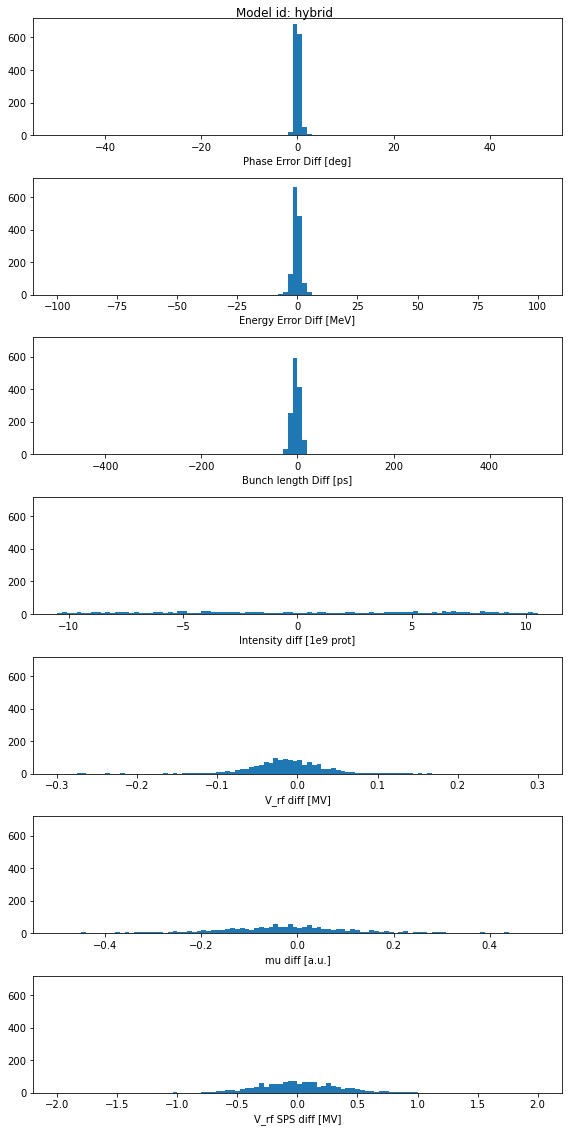

In [7]:

y_test_unnorm = unnormalize_params(
    y_test[:, 0], y_test[:, 1], y_test[:, 2],
    y_test[:, 3], y_test[:, 4], y_test[:, 5],
    y_test[:, 6], normalization=normalization)

y_pred_unnorm = unnormalize_params(
    test_pred[:, 0], test_pred[:, 1], test_pred[:, 2],
    test_pred[:, 3], test_pred[:, 4], test_pred[:, 5],
    test_pred[:, 6], normalization=normalization)

diffs = np.array(y_pred_unnorm).T - np.array(y_test_unnorm).T
print(diffs.shape)
fig, axes = plt.subplots(ncols=1, nrows=len(var_names), sharex=False,
                         sharey=True, figsize=(8, 16))
fig.suptitle(f'Model id: {timestamp}')

plt.sca(axes[0])
plt.hist(diffs[:, 0], bins=100, range=(-50, 50))
plt.xlabel('Phase Error Diff [deg]')
plt.sca(axes[1])
plt.hist(diffs[:, 1], bins=100, range=(-100, 100))
plt.xlabel('Energy Error Diff [MeV]')
plt.sca(axes[2])
plt.hist(diffs[:, 2]*1e12, bins=100, range=(-500, 500))
plt.xlabel('Bunch length Diff [ps]')
plt.sca(axes[3])
plt.hist(diffs[:, 3]*1e-10, bins=100, range=(-10.5, 10.5))
plt.xlabel('Intensity diff [1e9 prot]')
plt.sca(axes[4])
plt.hist(diffs[:, 4], bins=100, range=(-0.3, 0.3))
plt.xlabel('V_rf diff [MV]')
plt.sca(axes[5])
plt.hist(diffs[:, 5], bins=100, range=(-0.5, 0.5))
plt.xlabel('mu diff [a.u.]')
plt.sca(axes[6])
plt.hist(diffs[:, 6], bins=100, range=(-2, 2))
plt.xlabel('V_rf SPS diff [MV]')
plt.tight_layout()

